In [1]:
import scanpy
import numpy as np
import scprep
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import ranksums
import matplotlib

In [2]:
stz = scanpy.read_h5ad('data/stz_beta_ins1_ins2.h5ad')
stz_ctrl = stz[stz.obs['groups_named_broad_cond'] == 'beta_Ctrl']
stz_treatment = stz[stz.obs['treatment'] == 'Vehicle-STZ']
proliferation = np.load('results/gcs_4tp_2.npy')

## Visualize trajectory

In [8]:
cmap = {'Ins_1': 'salmon', 'Vehicle-STZ': 'darkseagreen', 'β1': 'lightblue', 'β2': 'cornflowerblue', 'β-mSTZ': 'midnightblue','Ctrl': 'darkmagenta', 'Vehicle-STZ': 'darkseagreen'}

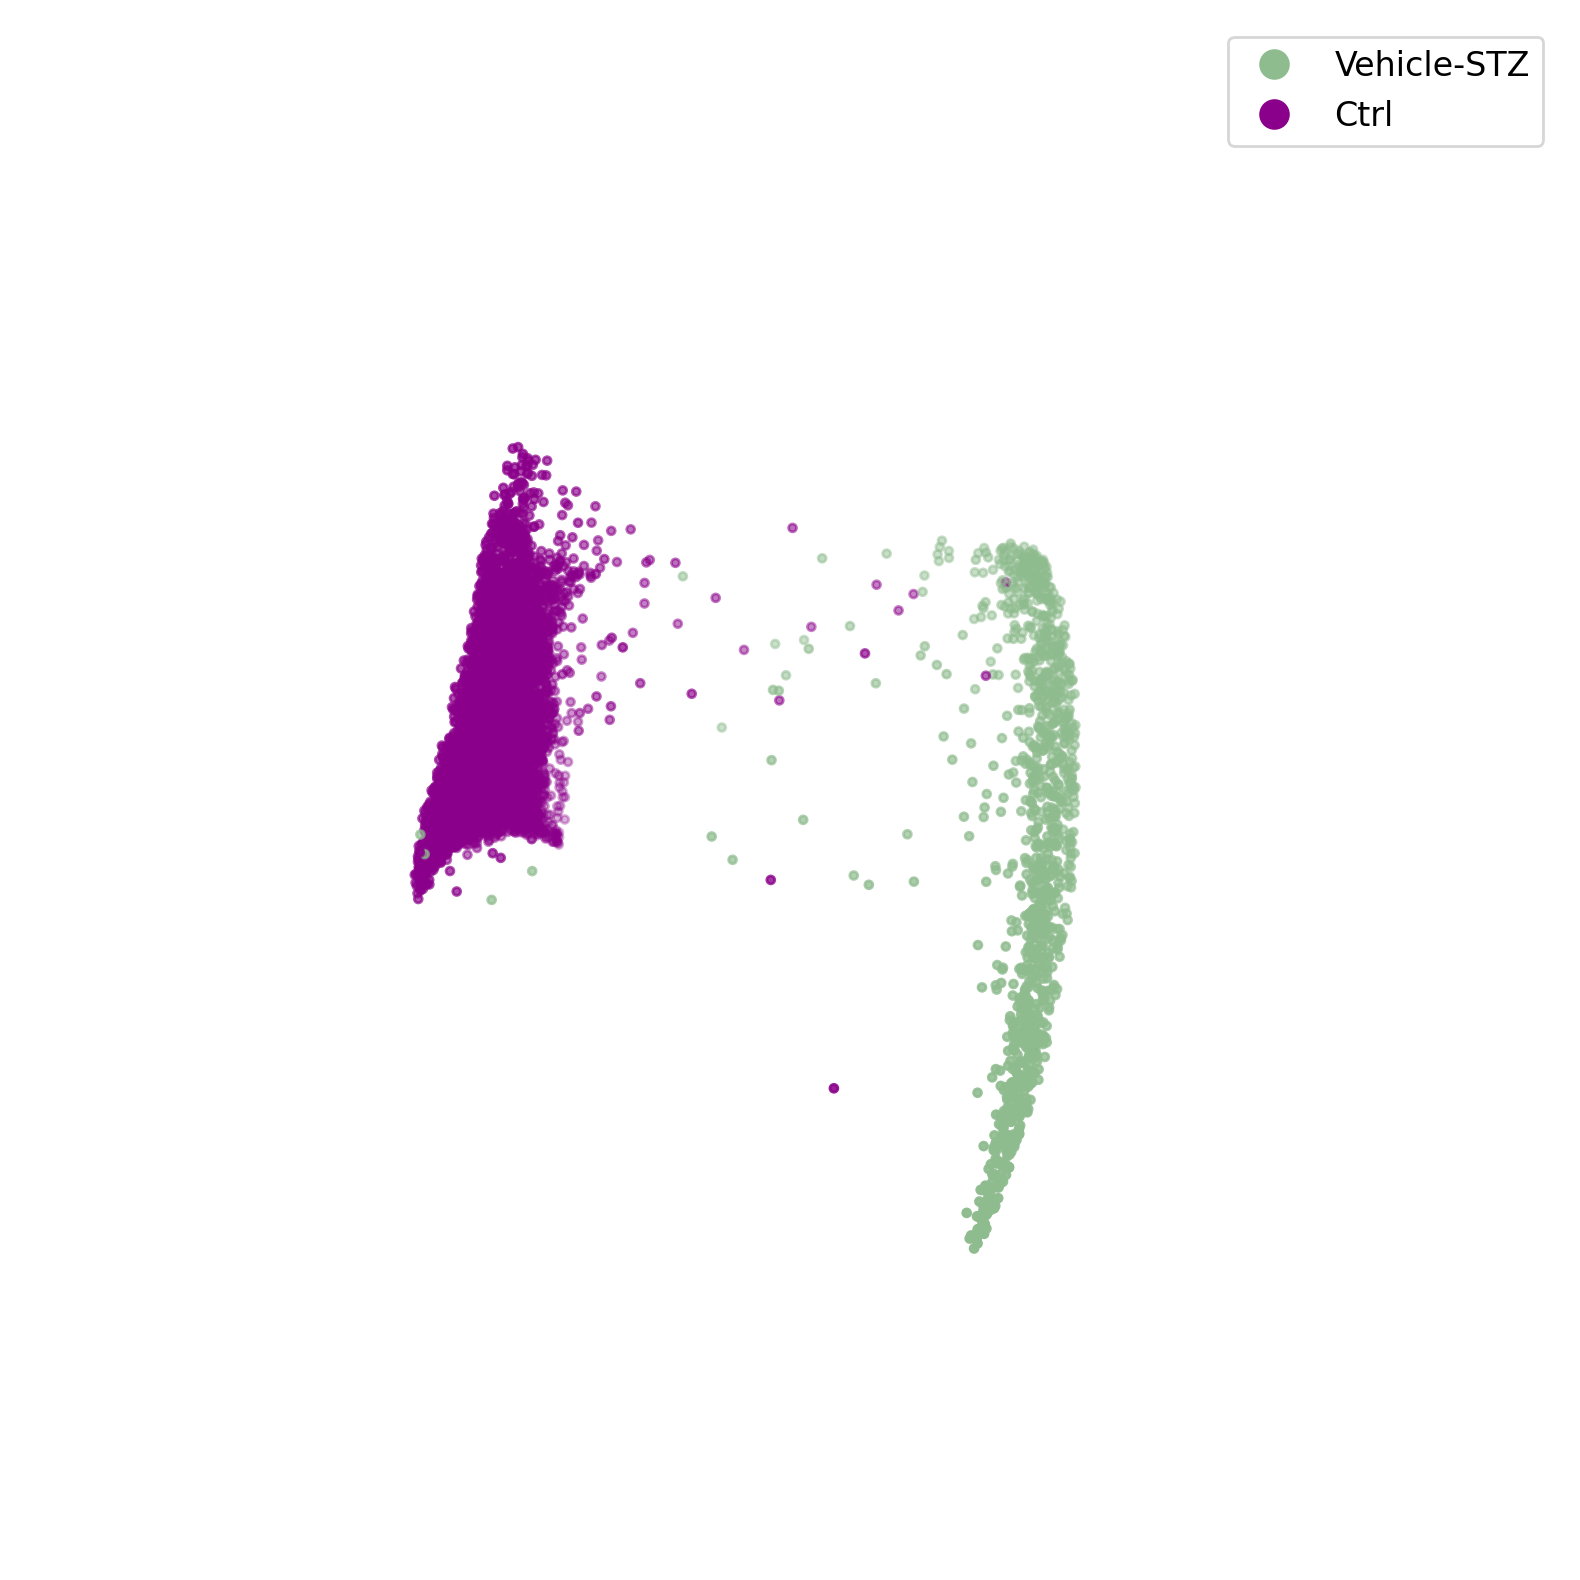

In [9]:
fig = plt.figure(figsize=(10,8), dpi=200)
ax = fig.add_subplot(projection='3d')
scprep.plot.scatter3d(stz.obsm['data_magic_pc_norm'], c=stz.obs['treatment'], s=8, figsize=(6,6), cmap=cmap, ticks=[], ax=ax, azim=-60)
ax.axis('off')
plt.tight_layout()
fig.savefig('figures/treatment.png', dpi=200)

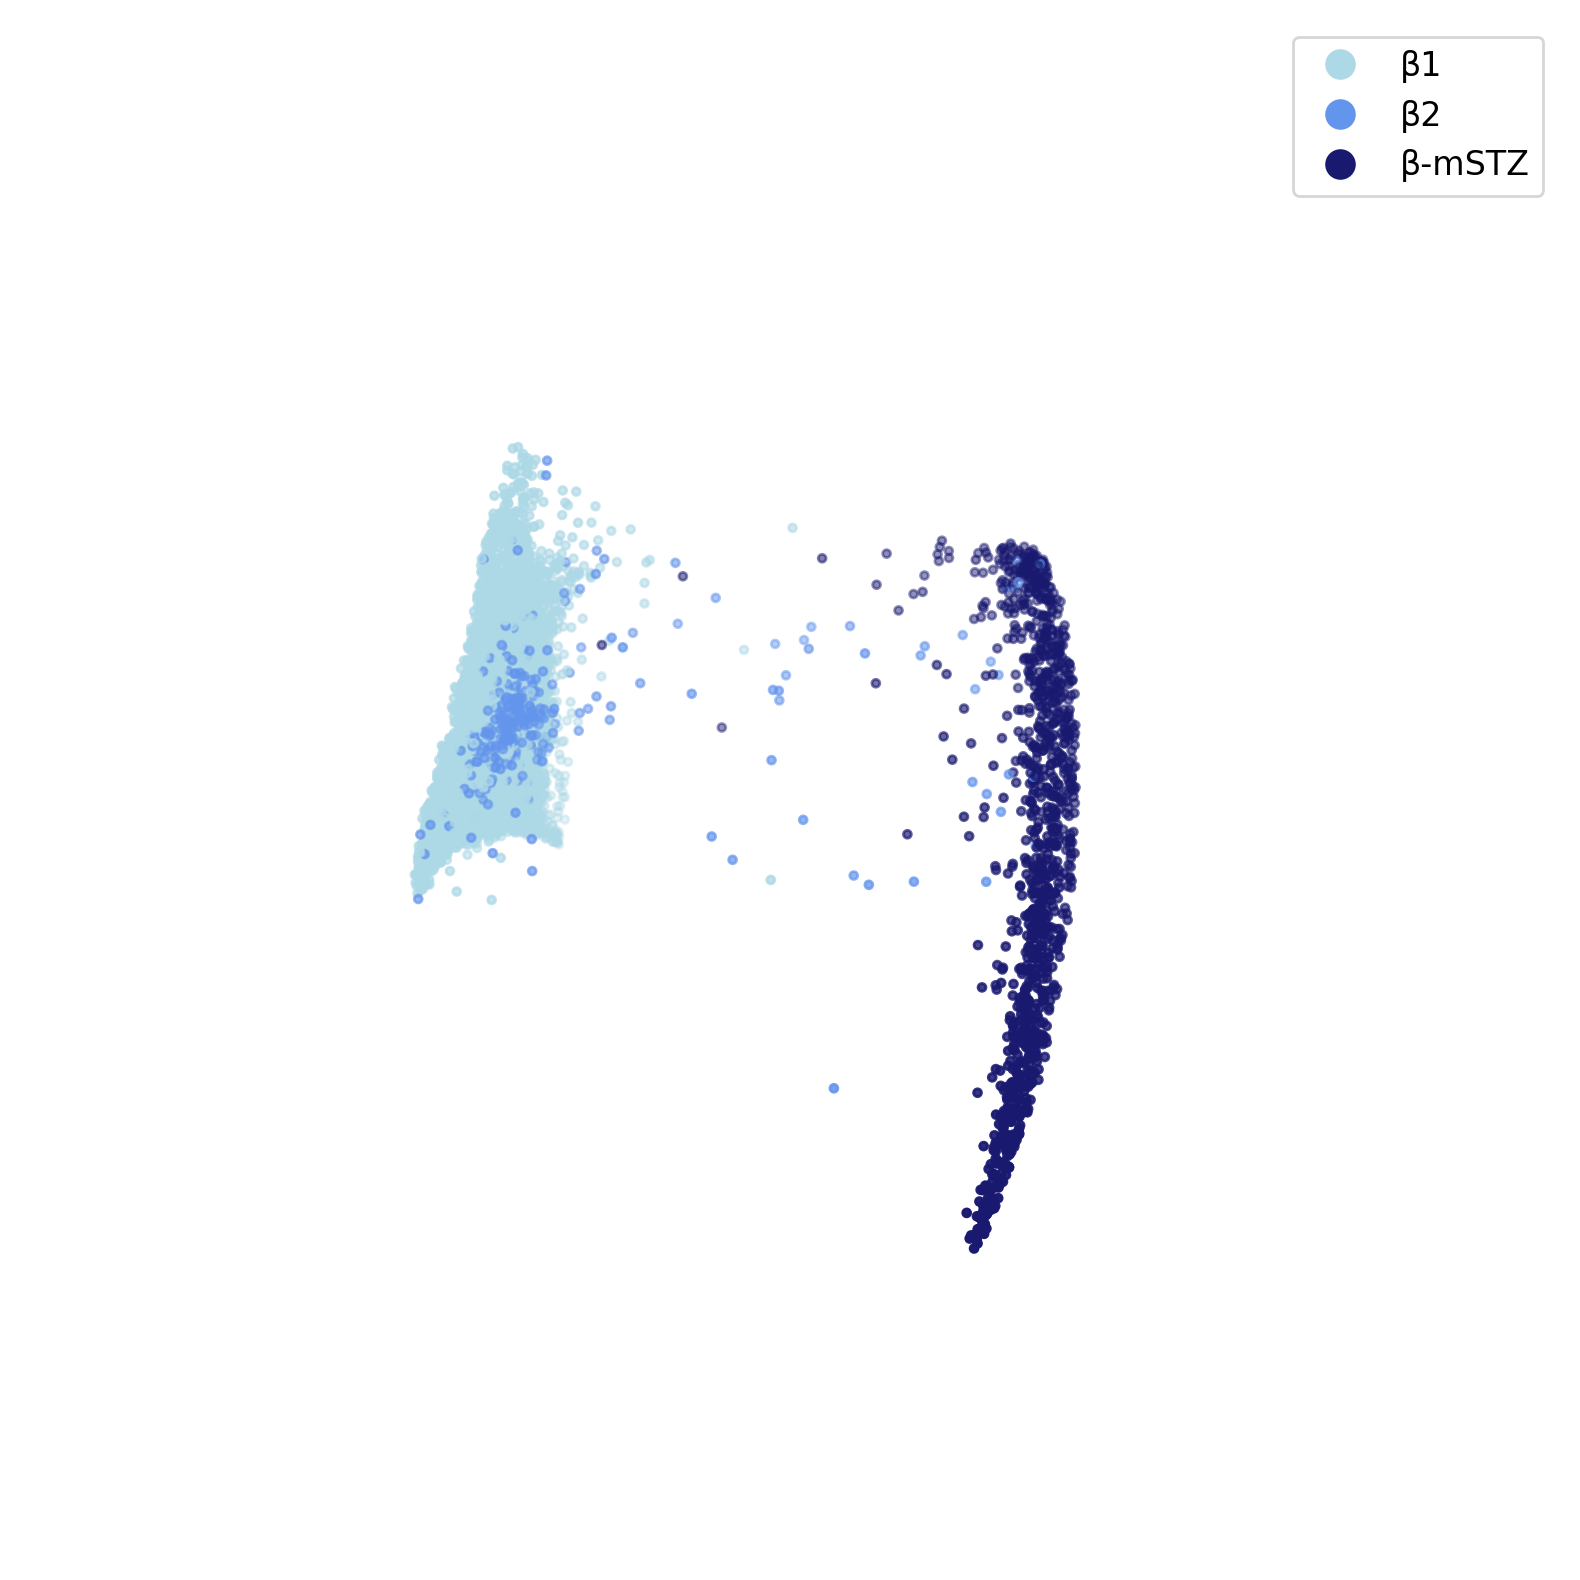

In [11]:
fig = plt.figure(figsize=(10,8), dpi=200)
ax = fig.add_subplot(projection='3d')
scprep.plot.scatter3d(stz.obsm['data_magic_pc_norm'], s=8, c=stz.obs['groups_named_fine'], figsize=(6,6), cmap=cmap, ticks=[], ax=ax, azim=-60)
ax.axis('off')
plt.tight_layout()
fig.savefig('figures/subclusters.png', dpi=200)

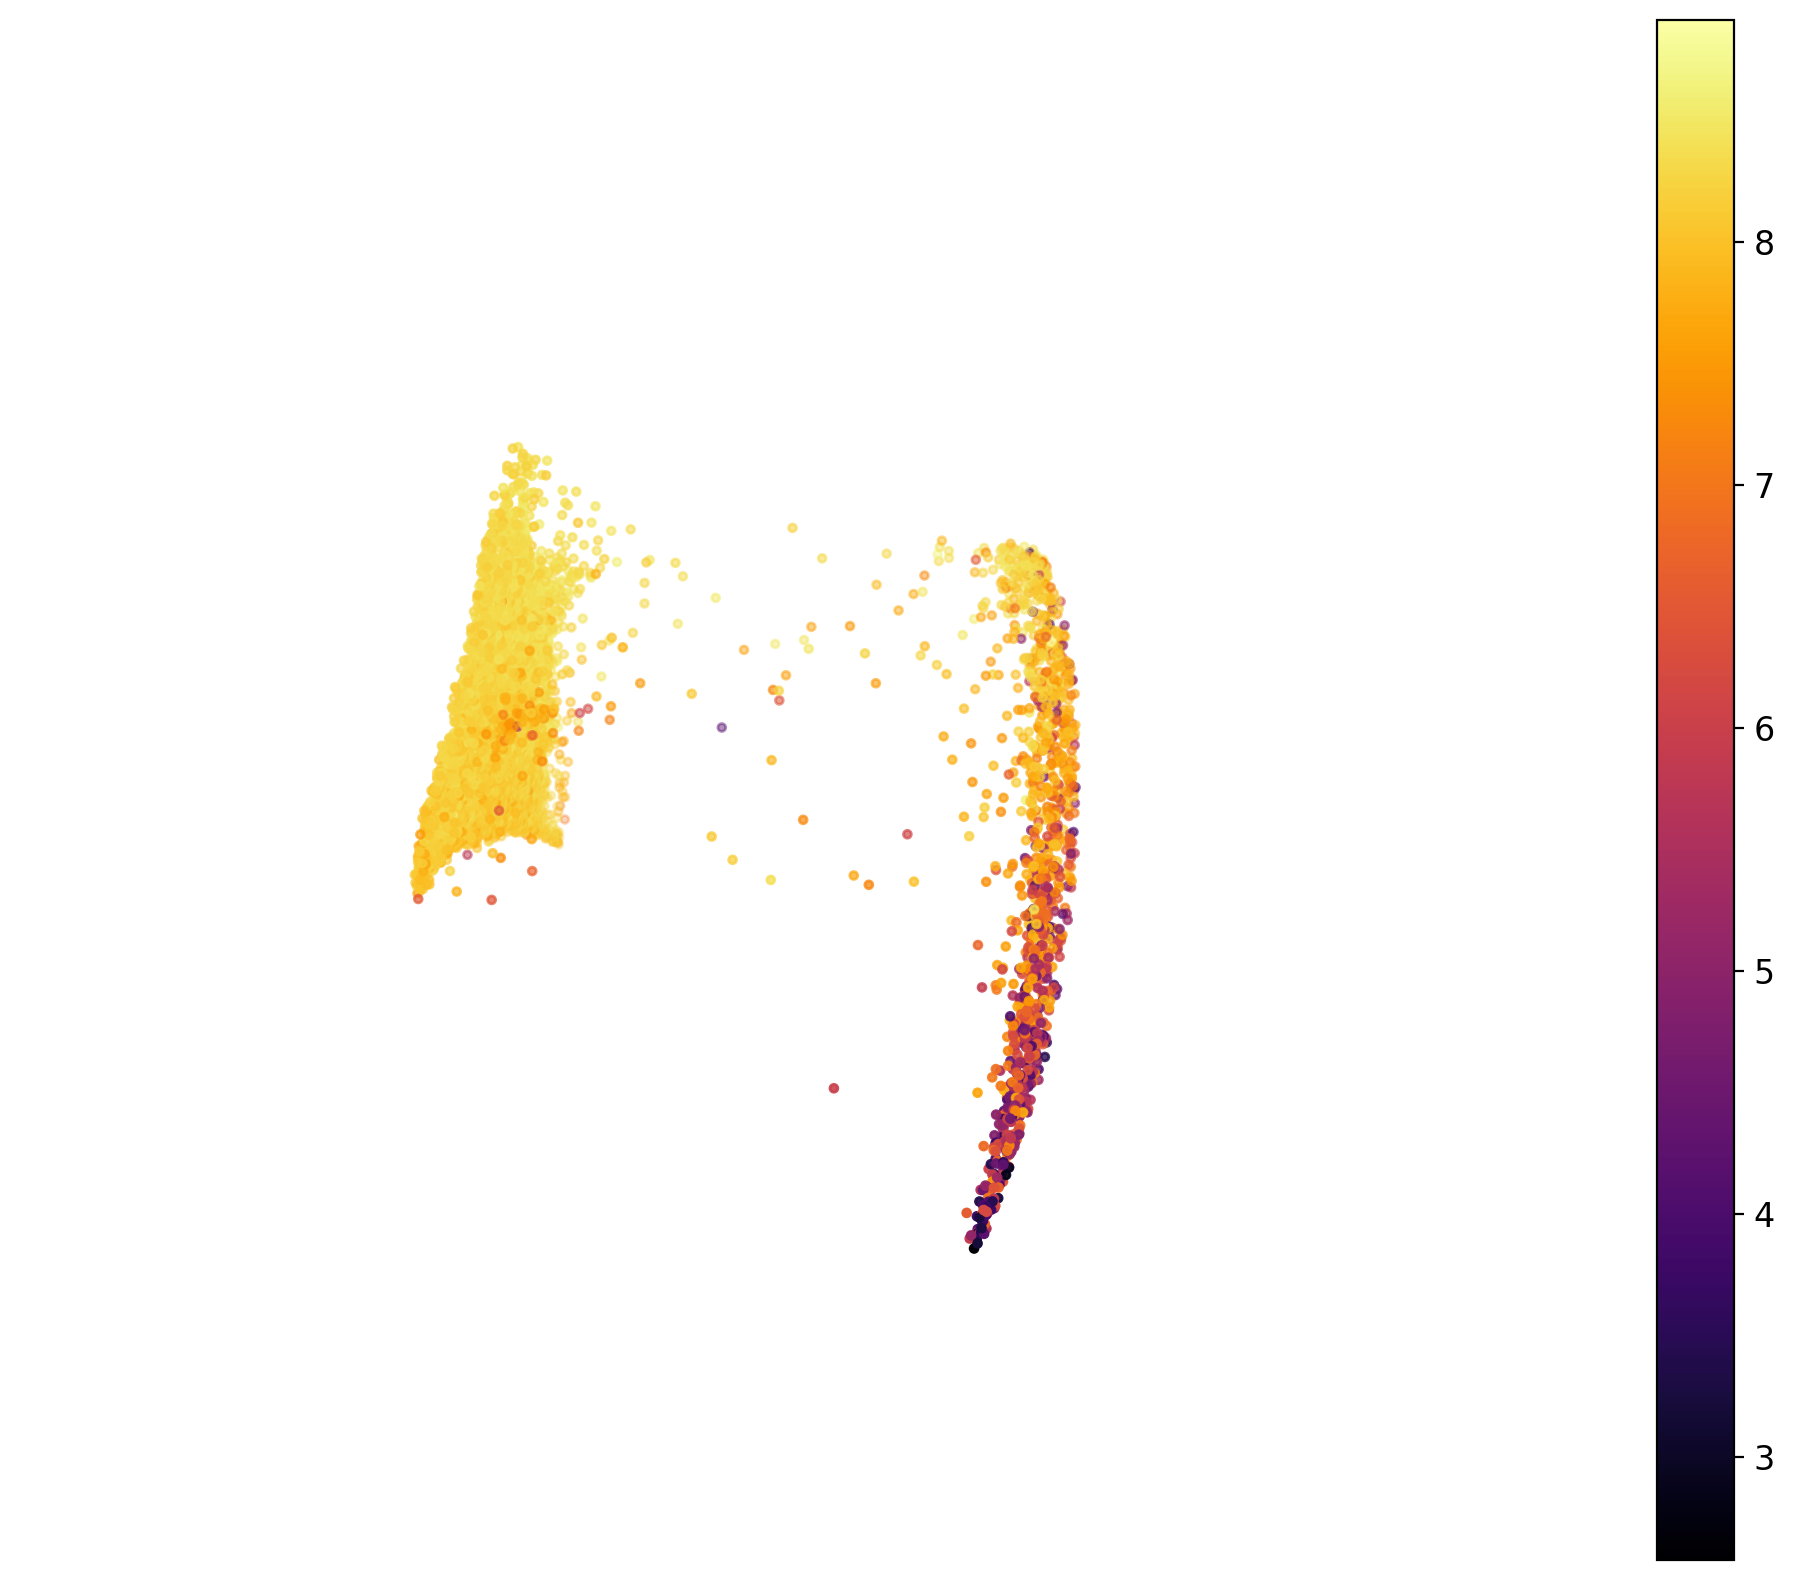

In [12]:
fig = plt.figure(figsize=(10,8), dpi=200)
ax = fig.add_subplot(projection='3d')
scprep.plot.scatter3d(stz.obsm['data_magic_pc_norm'], s=8, c=stz.to_df()['Ins1'], figsize=(6,6), ticks=[], ax=ax, legend_loc=(1.05,0), azim=-60)
plt.tight_layout()
ax.axis('off')
fig.savefig('figures/Ins1.png', dpi=200)

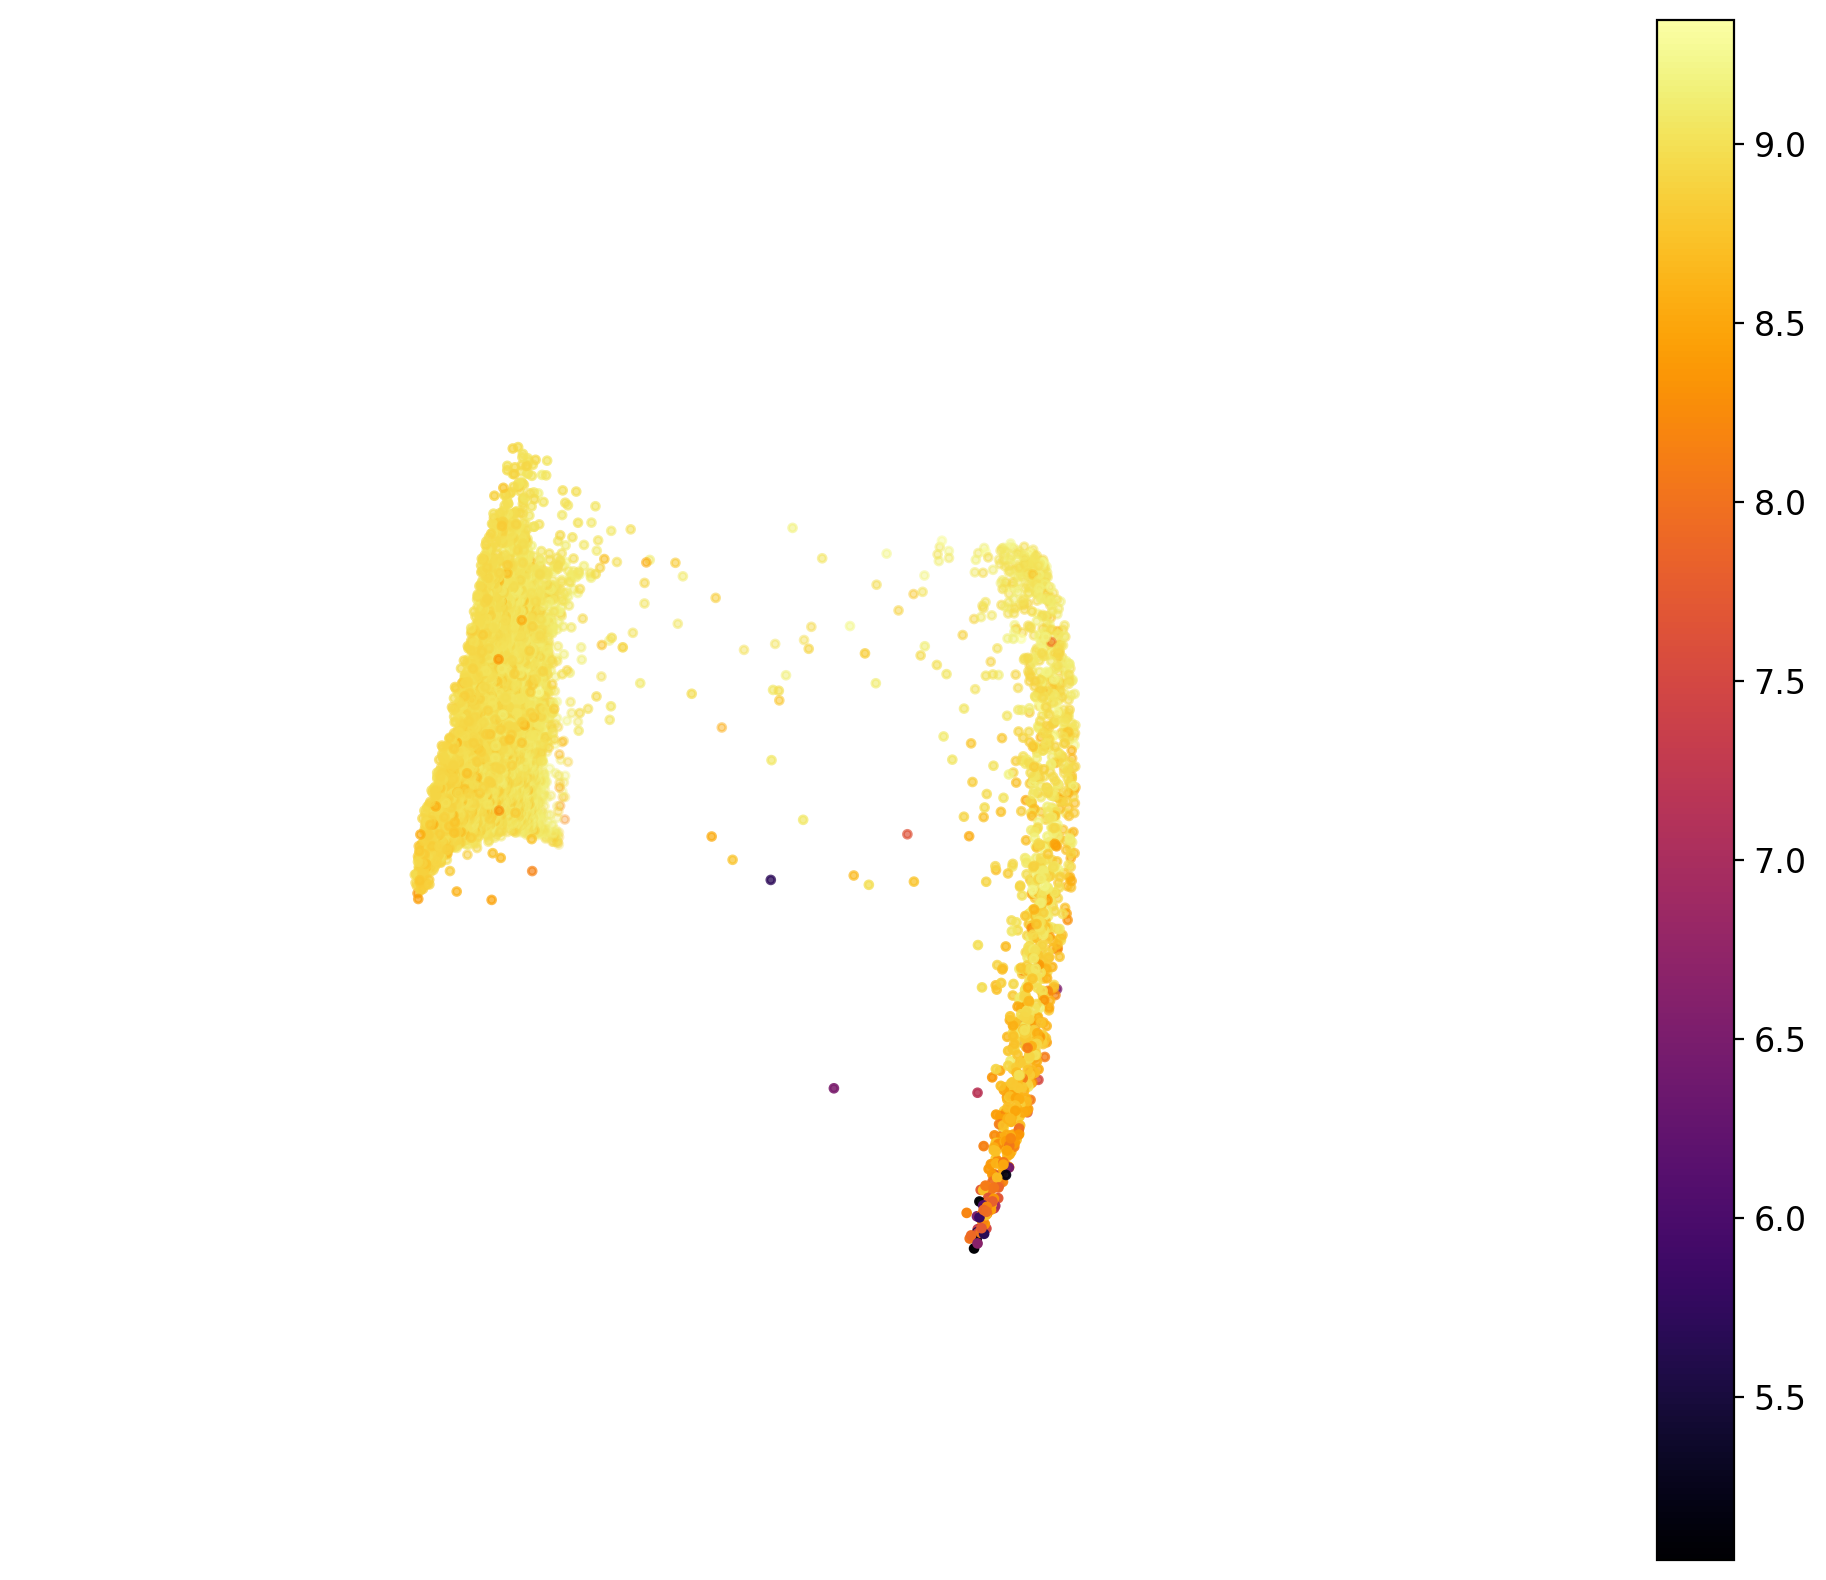

In [13]:
fig = plt.figure(figsize=(10,8), dpi=200)
ax = fig.add_subplot(projection='3d')
scprep.plot.scatter3d(stz.obsm['data_magic_pc_norm'], c=stz.to_df()['Ins2'], ticks=[], ax=ax, legend_loc=(1.05,0), azim=-60, s=8)
plt.tight_layout()
ax.axis('off')
fig.savefig('figures/Ins2.png', dpi=200)

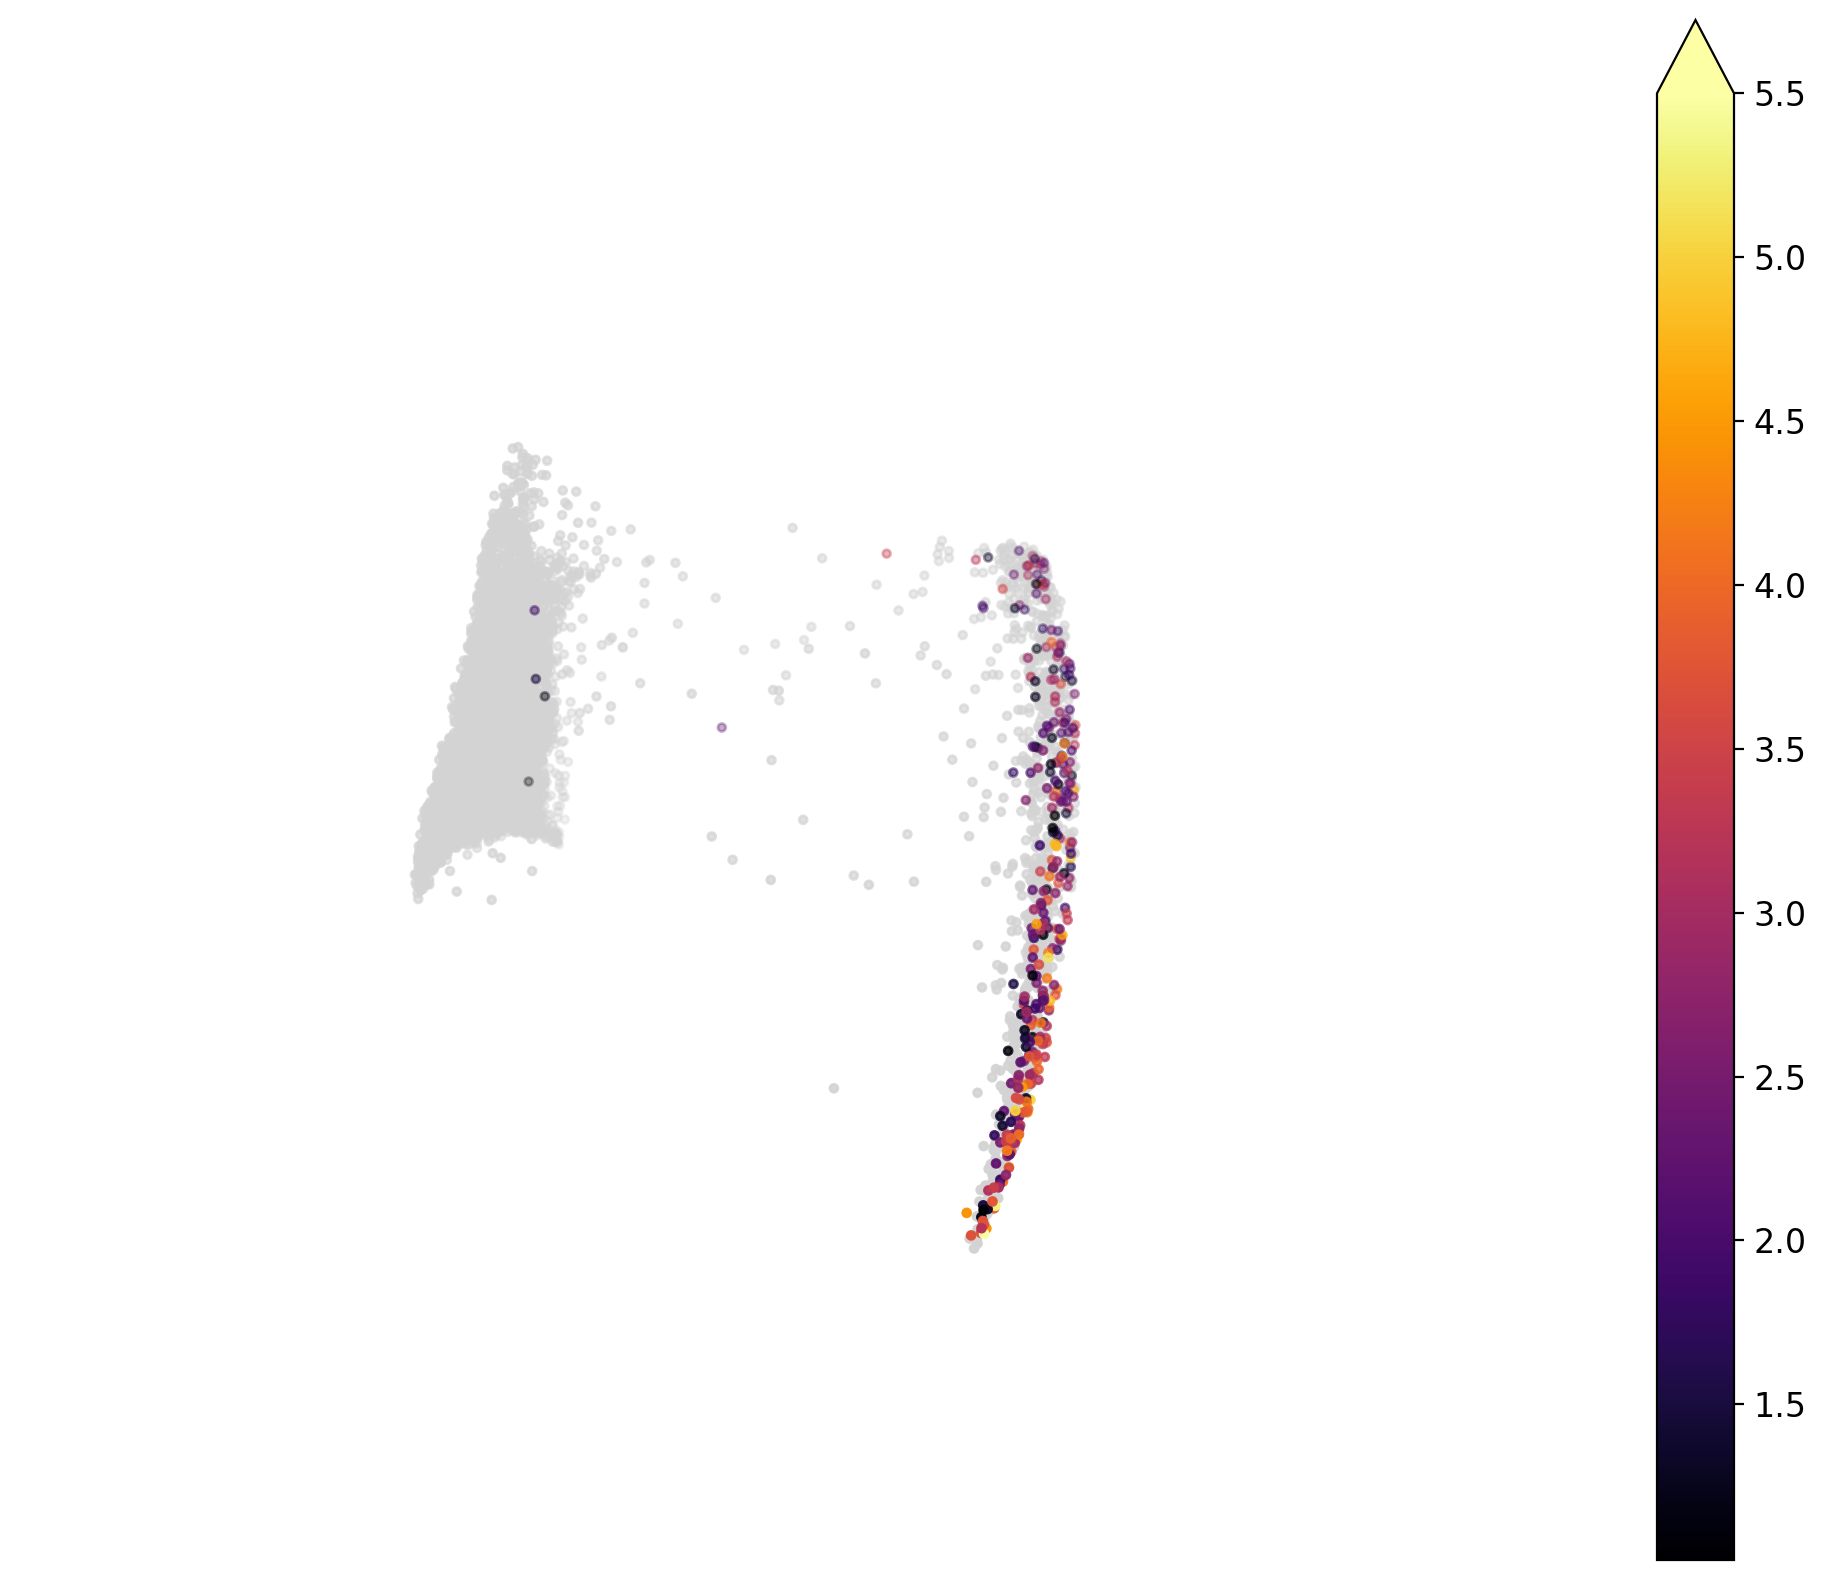

In [14]:
fig = plt.figure(figsize=(10,8), dpi=200)
ax = fig.add_subplot(projection='3d')
scprep.plot.scatter3d(stz.obsm['data_magic_pc_norm'], c='lightgray', ticks=[], ax=ax, legend_loc=(1.05,0), azim=-60, s=8, mask=stz.to_df()['Cck'] <=1)
scprep.plot.scatter3d(stz.obsm['data_magic_pc_norm'], c=stz.to_df()['Cck'], ticks=[], ax=ax, legend_loc=(1.05,0), azim=-60, s=8,
                      mask=stz.to_df()['Cck'] > 1, vmax=5.5)
plt.tight_layout()
ax.axis('off')
fig.savefig('figures/Cck.png', dpi=200)

## Proliferation score

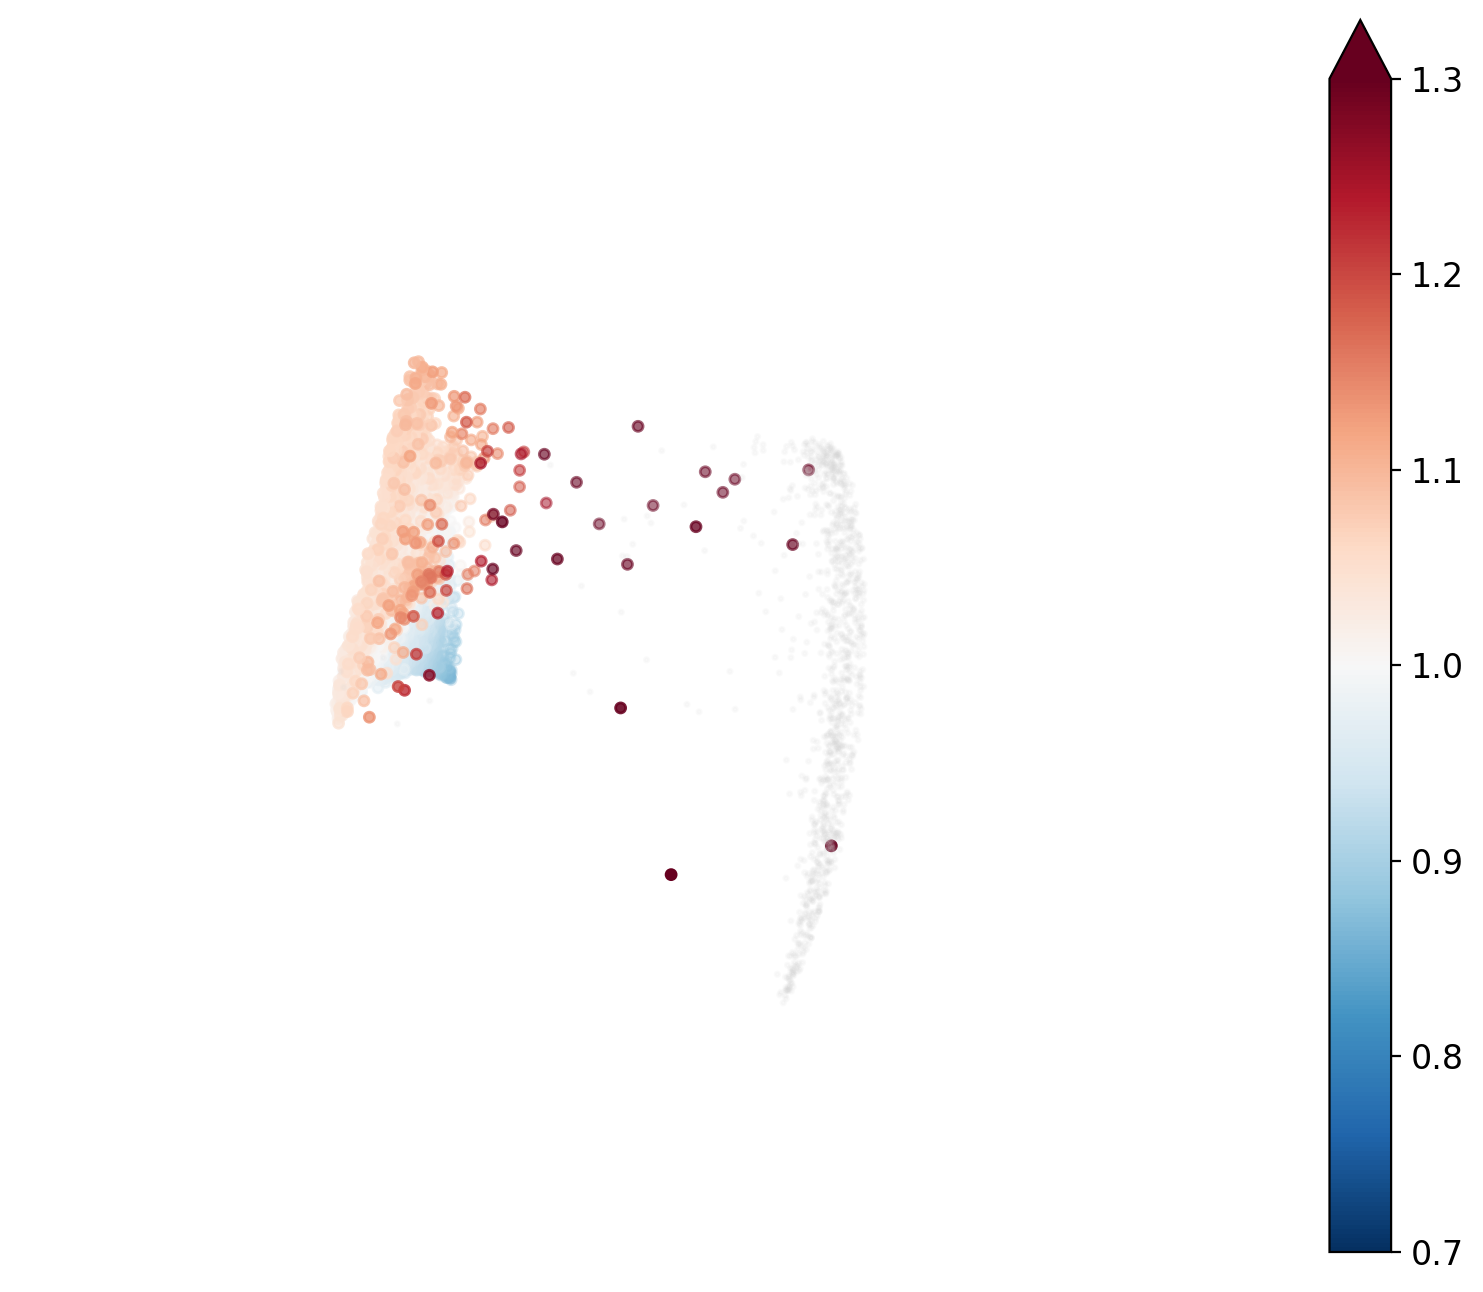

In [16]:
fig = plt.figure(figsize=(10,8), dpi=200)
ax = fig.add_subplot(111, projection='3d')
scprep.plot.scatter3d(stz.obsm['data_magic_pc_norm'], c='lightgray', ax=ax, alpha=0.1, mask=stz.obs.treatment != 'Ctrl')
scprep.plot.scatter3d(stz.obsm['data_magic_pc_norm'][stz.obs['TrajectoryNet_timepoints'] != 3], c=proliferation, ax=ax, s=13, 
                      mask=stz.obs.treatment[stz.obs['TrajectoryNet_timepoints'] != 3] == 'Ctrl', vmin=0.7, vmax=1.3, cmap='RdBu_r', ticks=None)
ax.axis('off')
fig.savefig('figures/Ctrl_proliferation_score.png', dpi=300)

In [41]:
ctrl_growth_coeff = pd.DataFrame(proliferation[[stz.obs.treatment[stz.obs['TrajectoryNet_timepoints'] != 3] == 'Ctrl']],
                                index =stz[stz.obs['TrajectoryNet_timepoints'] != 3][stz.obs.treatment[stz.obs['TrajectoryNet_timepoints'] != 3] == 'Ctrl'].obs_names)
ctrl_growth_coeff[1] = stz_ctrl.obs.loc[ctrl_growth_coeff.index]['groups_named_fine']

/tmp/ipykernel_3550262/220034378.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ctrl_growth_coeff = pd.DataFrame(proliferation[[stz.obs.treatment[stz.obs['TrajectoryNet_timepoints'] != 3] == 'Ctrl']],


In [42]:
ctrl_growth_coeff = ctrl_growth_coeff[ctrl_growth_coeff[1] != 'β-mSTZ'] # 6 cells, focus on differences between b1 and b2

In [43]:
ctrl_growth_coeff[1] = ctrl_growth_coeff[1].astype('category').cat.remove_unused_categories()

/tmp/ipykernel_3550262/340550131.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(ctrl_growth_coeff, x=1, y=0, palette=cmap)
/tmp/ipykernel_3550262/340550131.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


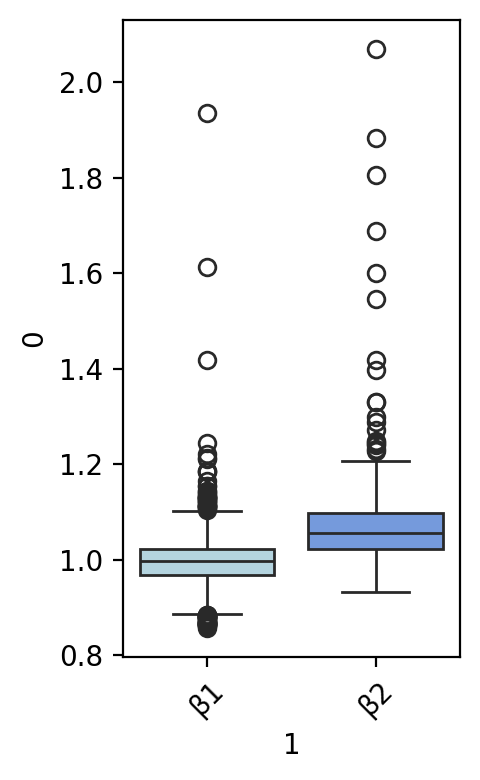

In [44]:
fig, ax = plt.subplots(figsize=(2.5,4), dpi=200)
ax = sns.boxplot(ctrl_growth_coeff, x=1, y=0, palette=cmap)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.tight_layout()
fig.savefig('figures/proliferation_rate_per_wt.png')

In [45]:
for at in ctrl_growth_coeff[1].cat.categories:
    print(f'β2 proliferation > {at} p =', ranksums(ctrl_growth_coeff[ctrl_growth_coeff[1] == 'β2'][0].tolist(),
                     ctrl_growth_coeff[ctrl_growth_coeff[1] == at][0].tolist(), alternative='greater').pvalue)

β2 proliferation > β1 p = 5.462724349692615e-72
β2 proliferation > β2 p = 0.5


## Heatmap

In [3]:
markers = pd.read_csv('../data/dotplot_presentation_beta_cell_markers', dtype=str, header=None)
markers.columns = ['group', 'gene']

In [4]:
unique_groups = markers['group'].drop_duplicates().values
from collections import OrderedDict
markers_dict = OrderedDict()
for group in unique_groups:
    markers_dict[group] = list(markers[markers['group'] == group]['gene'])

In [5]:
scanpy.set_figure_params(dpi=200, dpi_save=200)

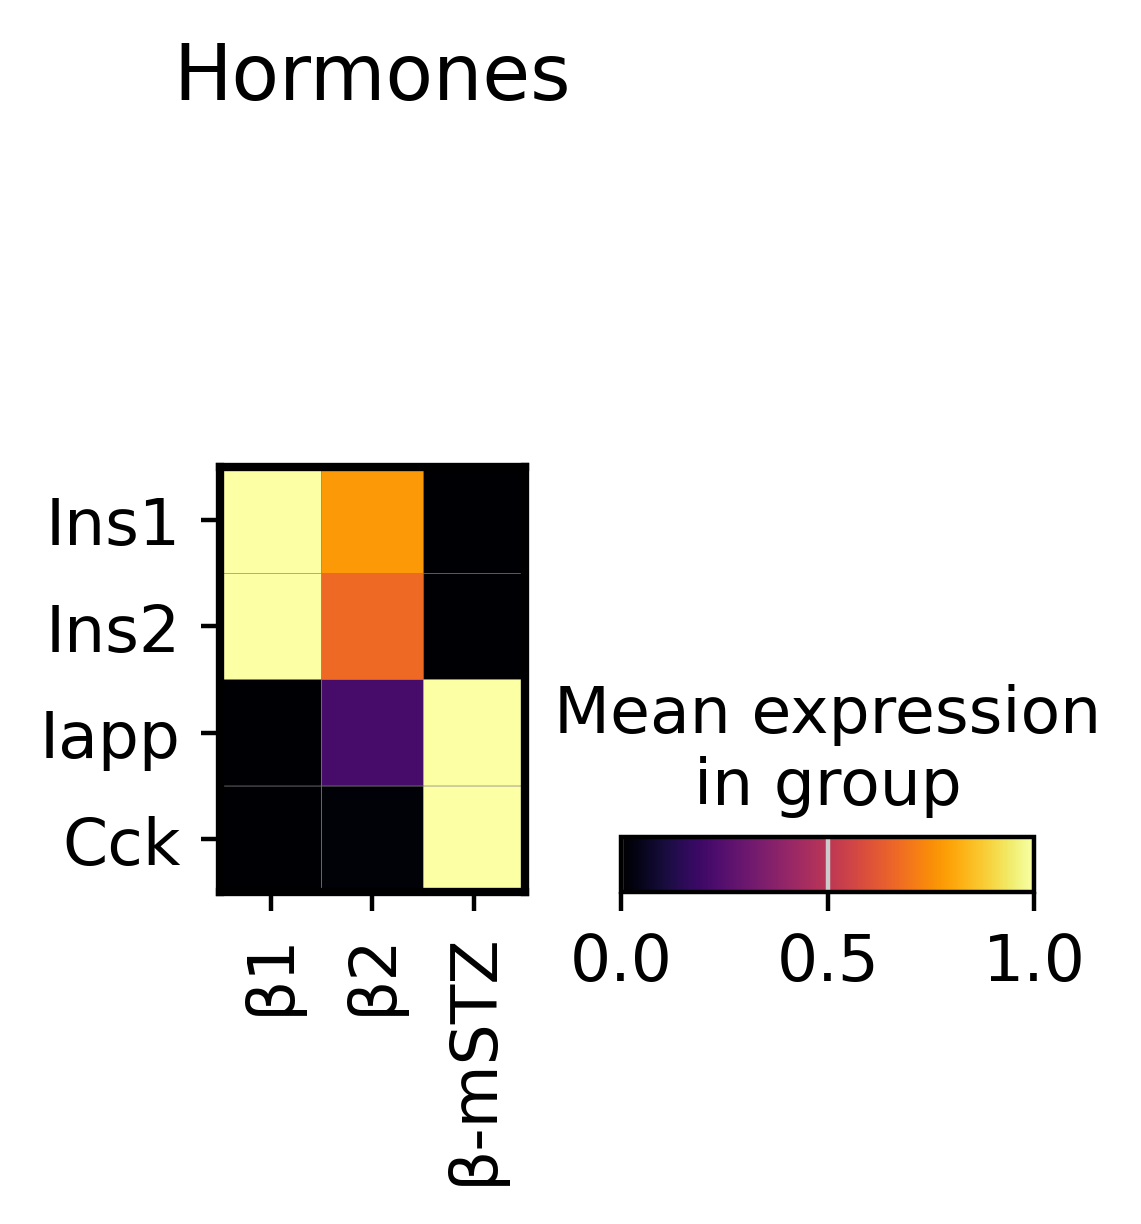

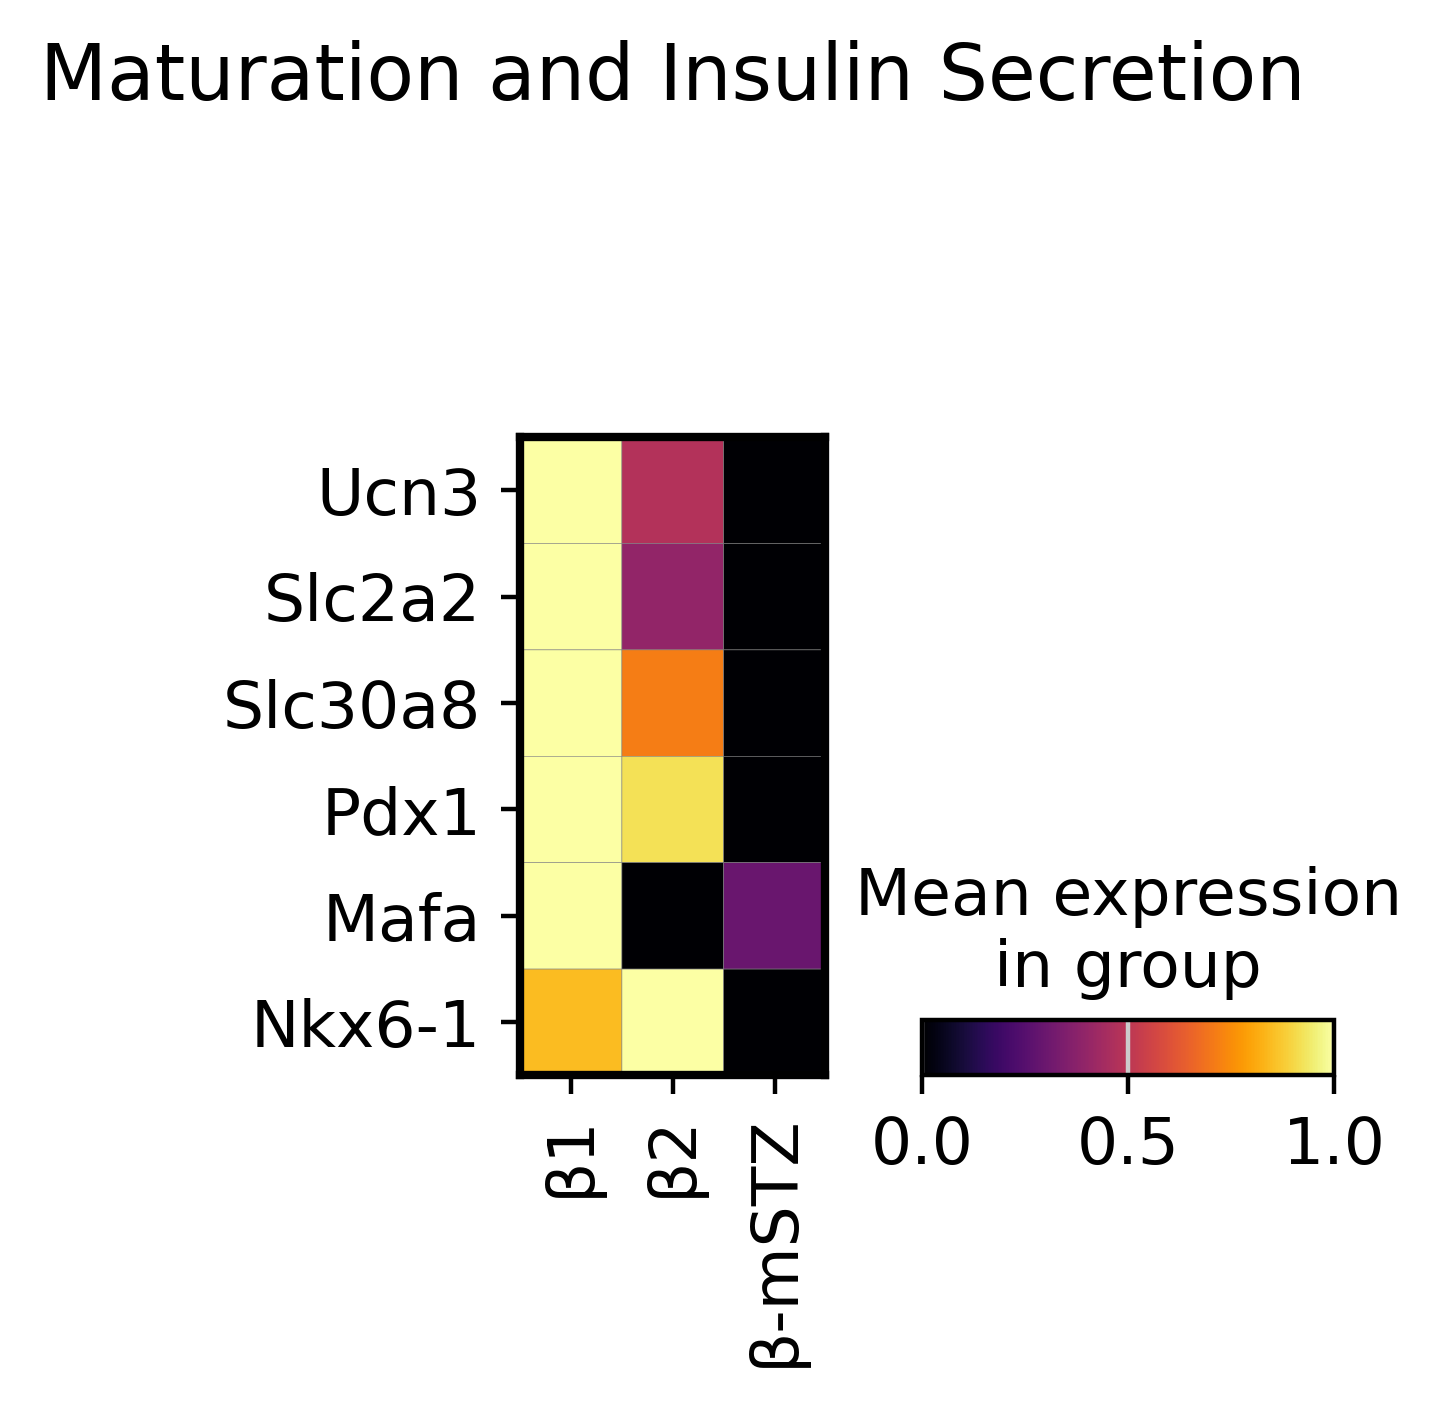

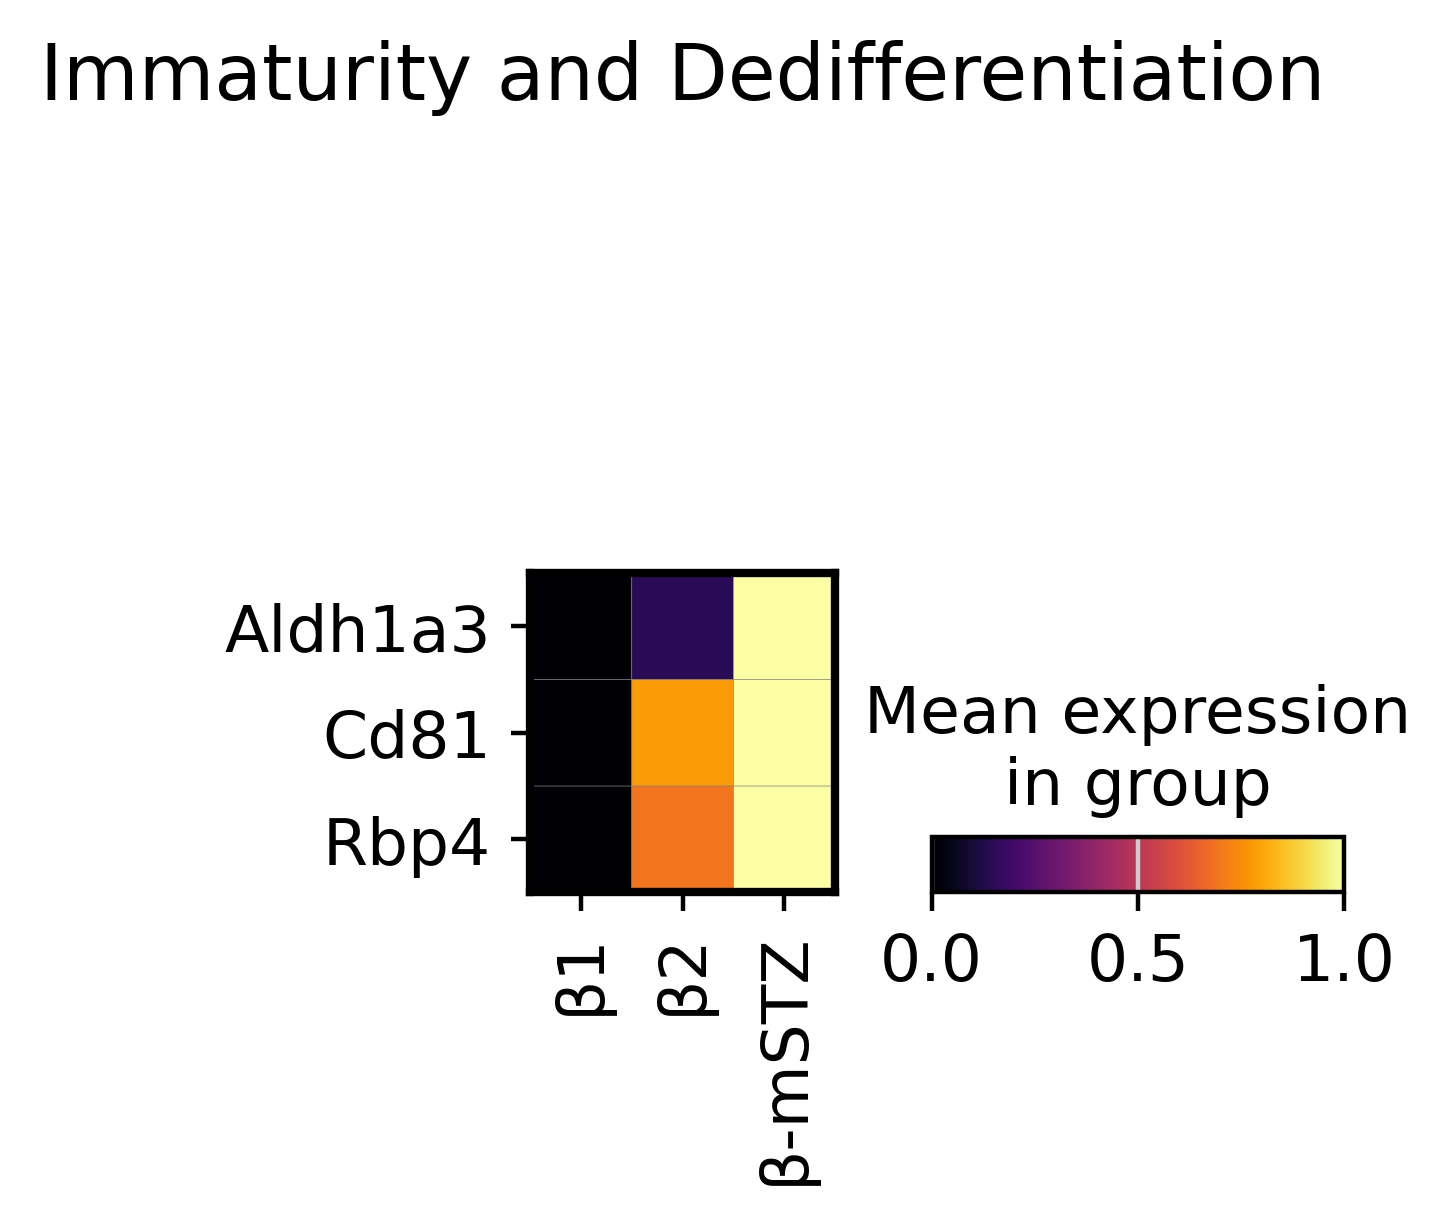

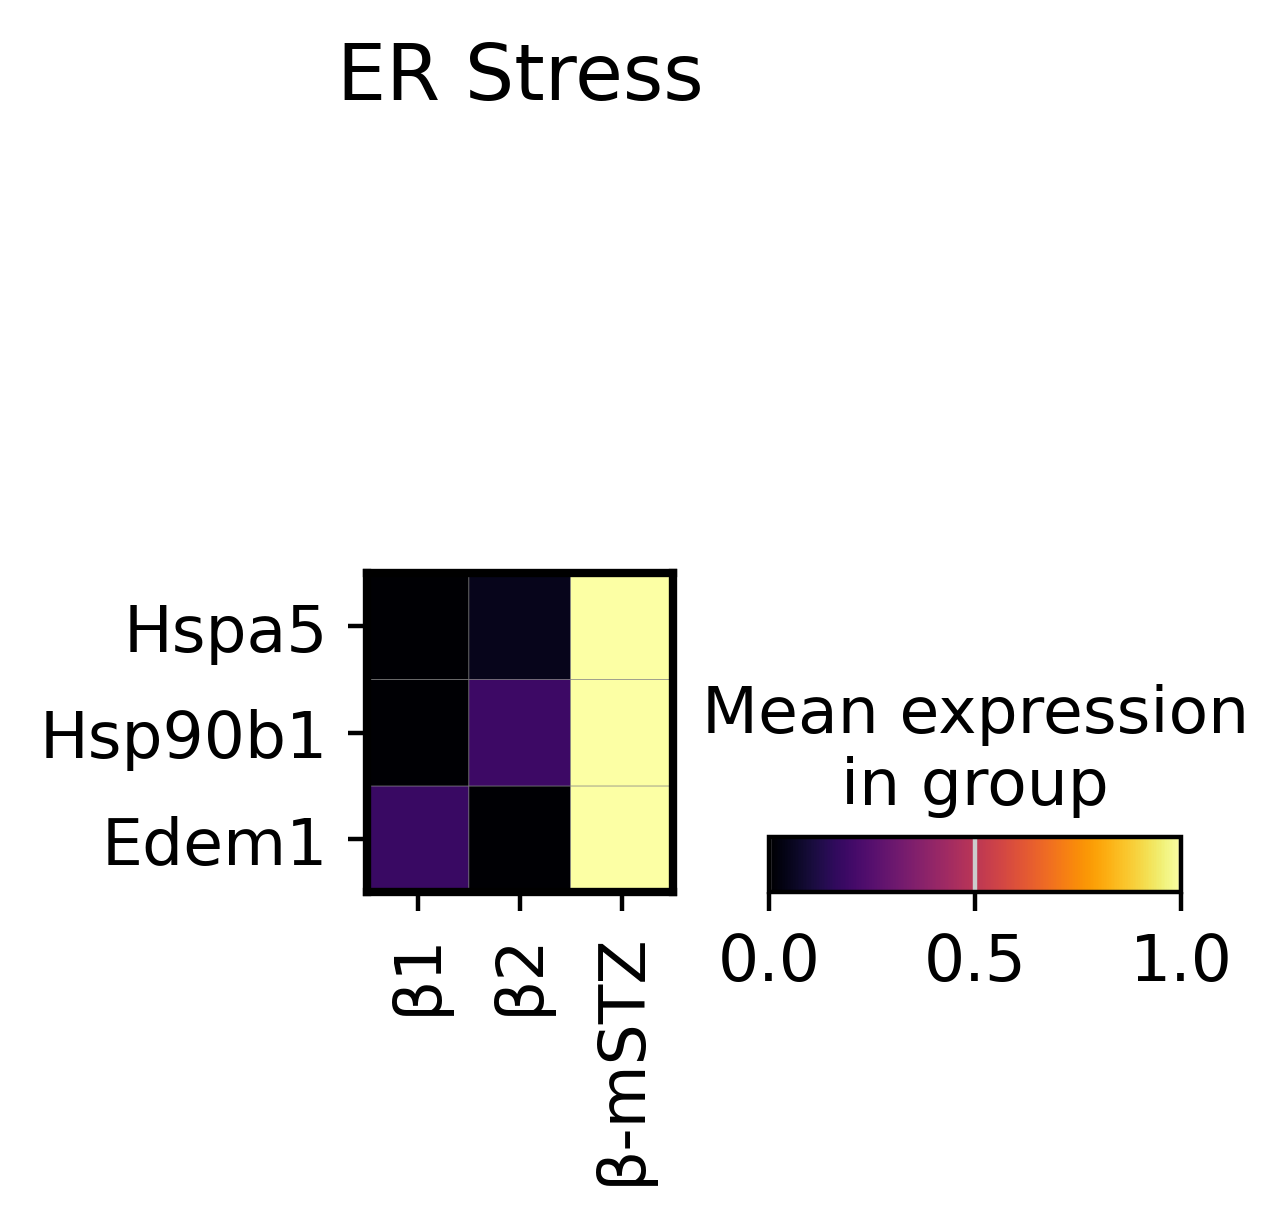

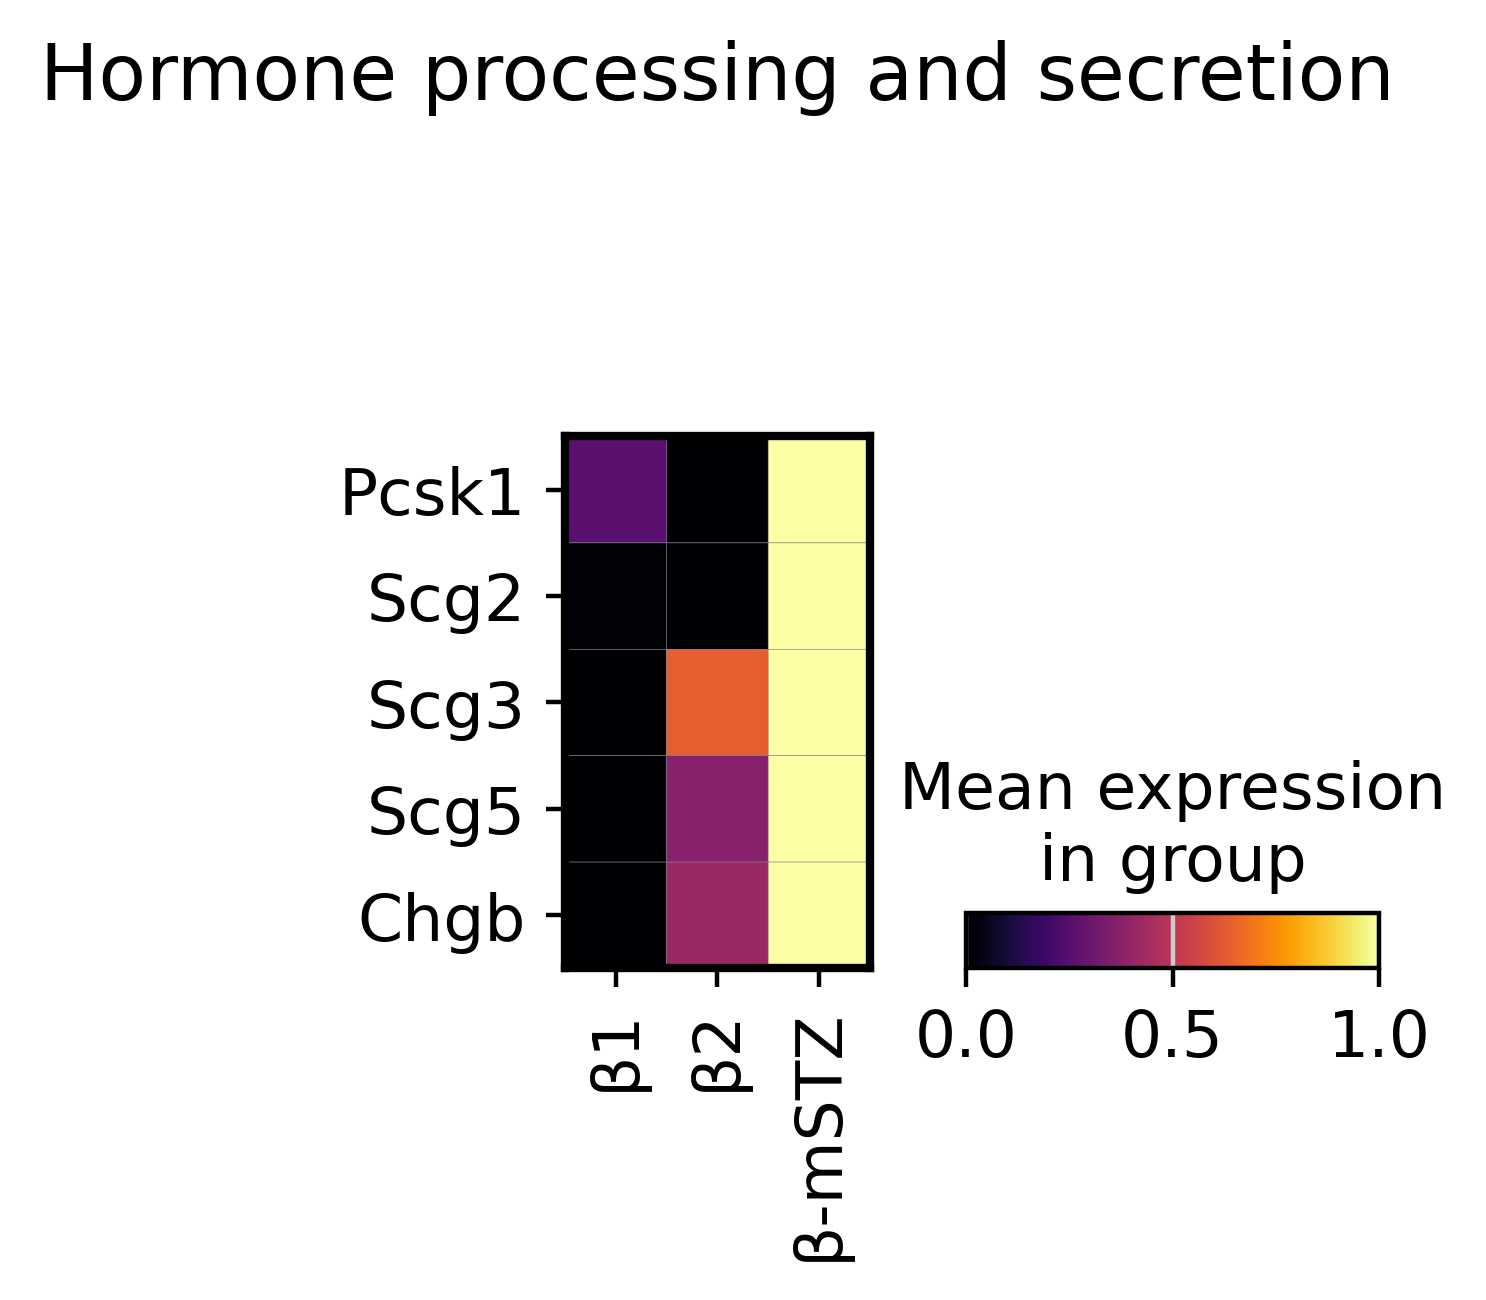

In [6]:
for key,vals in markers_dict.items():
    scanpy.pl.matrixplot(stz, var_names=vals, title=key,
              groupby=['groups_named_fine'], standard_scale='var',
              cmap='inferno', save=f'{key}_groups_named_fine.png', swap_axes=True)

## Mapping with archetypes

In [3]:
colors = list(sns.color_palette('Set1', n_colors=3)) + ['lightgray'] + list(sns.color_palette('Set2', n_colors=7).as_hex())
at_cmap = dict(zip(stz.obs['AT_committment_run_2'].sort_values().unique(), colors))

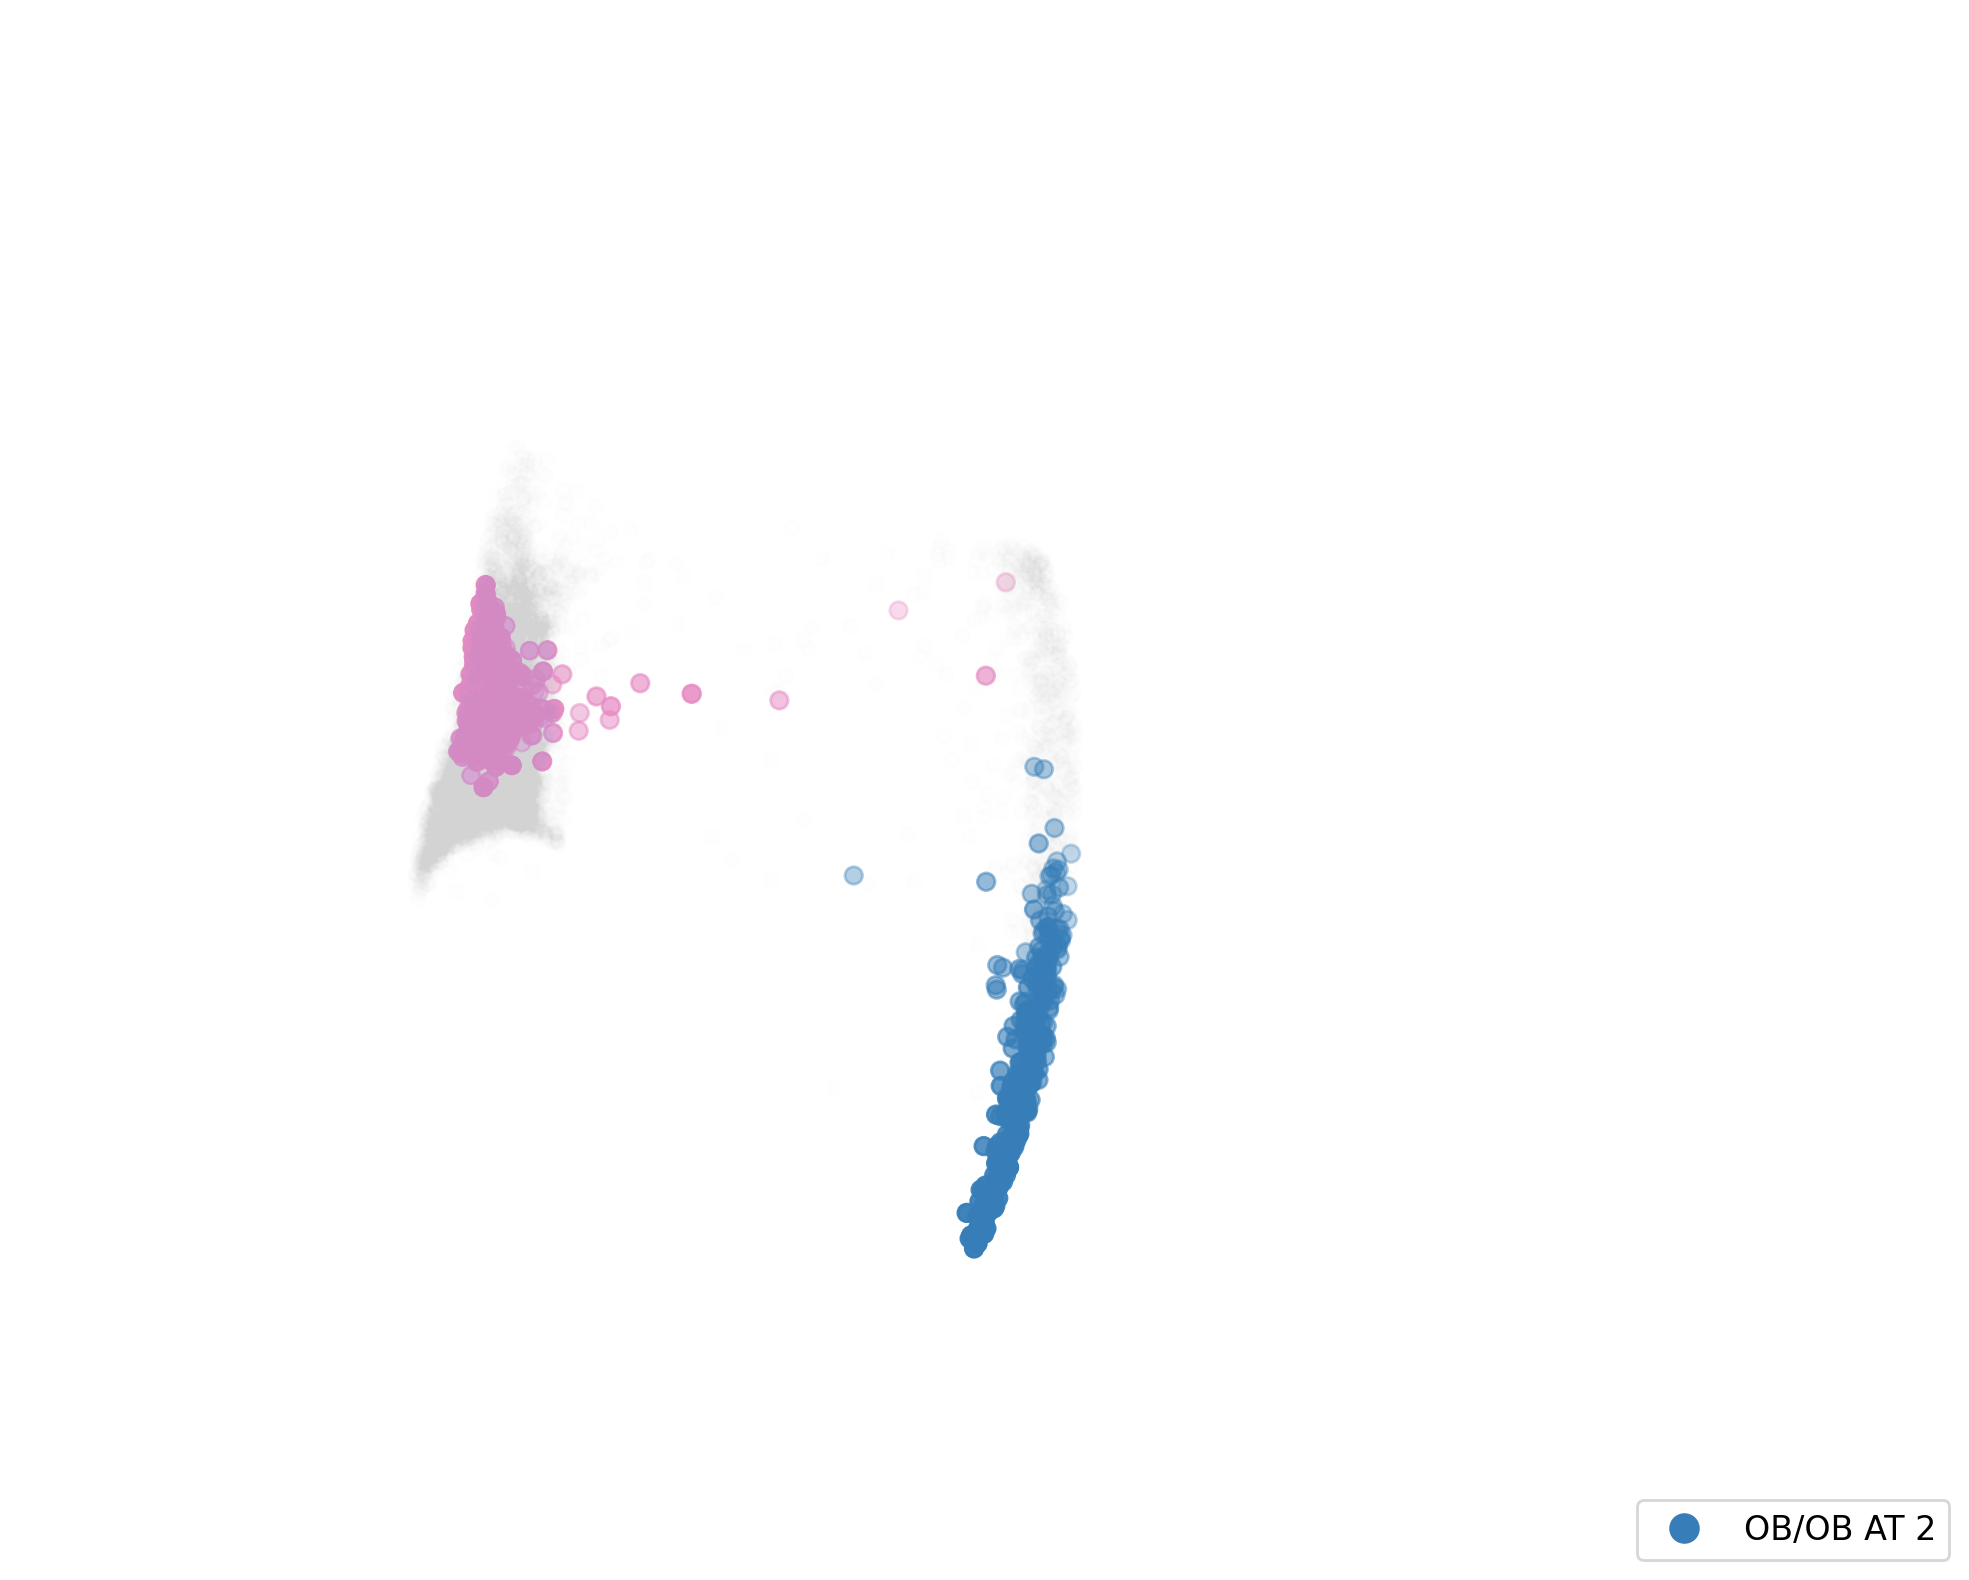

In [41]:
fig = plt.figure(figsize=(10,8), dpi=200)
ax = fig.add_subplot(projection='3d')
scprep.plot.scatter3d(stz.obsm['data_magic_pc_norm'], c='lightgray', ticks=[], ax=ax, legend_loc=(1.05,0), azim=-60, alpha=0.01, s=25,
                     mask=~stz.obs['AT_committment_run_2'].isin(['WT AT 4', 'OB/OB AT 2']))
scprep.plot.scatter3d(stz.obsm['data_magic_pc_norm'], c=stz.obs['AT_committment'], mask=stz.obs['AT_committment'] =='WT AT 4', cmap=at_cmap, ticks=[], ax=ax, legend_loc=(1.05,0), azim=-60, s=40,)
scprep.plot.scatter3d(stz.obsm['data_magic_pc_norm'], c=stz.obs['AT_committment'], mask=stz.obs['AT_committment'] =='OB/OB AT 2', cmap=at_cmap, ticks=[], ax=ax, legend_loc=(1.05,0), azim=-60, s=40,)
plt.tight_layout()
ax.axis('off')
fig.savefig('figures/mapped_archetypes.png', dpi=200)

In [63]:
observed = stz_ctrl.obs[stz_ctrl.obs['groups_named_fine'] == 'β2']['AT_committment'].value_counts()
expected =(stz_ctrl.obs['AT_committment'].value_counts() / stz_ctrl.n_obs) * observed.sum()
df1 = observed/expected

In [64]:
observed = stz_ctrl.obs[stz_ctrl.obs['groups_named_fine'] == 'β2']['AT_committment_run_2'].value_counts()
expected =(stz_ctrl.obs['AT_committment_run_2'].value_counts() / stz_ctrl.n_obs) * observed.sum()
df2 = observed/expected

In [65]:
df = pd.concat((df1, df2))

/tmp/ipykernel_2268195/4176371227.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df.index,
/tmp/ipykernel_2268195/4176371227.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


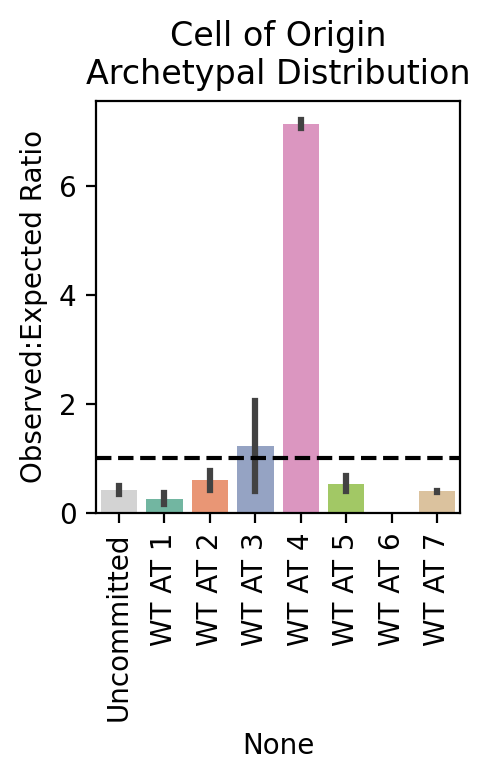

In [66]:
matplotlib.rc_file_defaults()
f = plt.figure(dpi=200, figsize=(2.5,4))
plt.title('Cell of Origin\nArchetypal Distribution', color='black')

ax = sns.barplot(x=df.index,
            y=df.values,
            palette=at_cmap)

plt.axhline(1, c='black', linestyle='dashed')
plt.ylabel('Observed:Expected Ratio')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
f.savefig(f'figures/mapped_to_Ins2.png', dpi=200)

In [46]:
stz_treatment.obs['Cck-hi'] = stz_treatment.to_df()['Cck'] > np.percentile(stz_treatment.to_df()['Cck'], 95)

In [59]:
observed = stz_treatment.obs[stz_treatment.obs['Cck-hi']]['AT_committment'].value_counts()
expected =(stz_treatment.obs['AT_committment'].value_counts() / stz_treatment.n_obs) * observed.sum()
df1 = observed/expected

In [60]:
observed = stz_treatment.obs[stz_treatment.obs['Cck-hi']]['AT_committment_run_2'].value_counts()
expected =(stz_treatment.obs['AT_committment_run_2'].value_counts() / stz_treatment.n_obs) * observed.sum()
df2 = observed/expected

In [61]:
df = pd.concat((df1, df2))

/tmp/ipykernel_2268195/2638905620.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df.index,
/tmp/ipykernel_2268195/2638905620.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


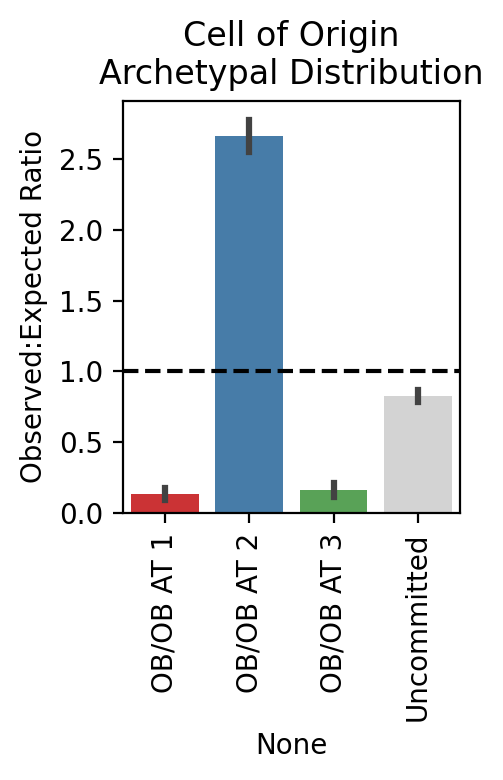

In [62]:
matplotlib.rc_file_defaults()
f = plt.figure(dpi=200, figsize=(2.5,4))
plt.title('Cell of Origin\nArchetypal Distribution', color='black')

ax = sns.barplot(x=df.index,
            y=df.values,
            palette=at_cmap)

plt.axhline(1, c='black', linestyle='dashed')
plt.ylabel('Observed:Expected Ratio')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
f.savefig(f'figures/mapped_to_Cck-hi.png', dpi=200)